# Topic Modeling para cada desafío

En esta notebook se realiza Topic Modeling con una variedad de metodos:

1. Latent Semantic Analysis (LSA)
2. Latent Dirichlet Allocation (LDA)
1. BERTopic

In [134]:
%%capture
!pip install -r requirements.txt --user

In [135]:
import pandas as pd
import regex as re
import unidecode
import nltk
import spacy

In [136]:
df = pd.read_excel('datos.xlsx')[['ID','texto','desafio']]

In [137]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

# Pre process and tokenization

In [138]:
%%capture
!python -m spacy download es_core_news_md

In [139]:
import stop_words as sw
stop_words = sw.get_stop_words('es')

def preprocess(textos, lemma=True, decode=True, alphanumeric=True, stopwords=True):
    
    """
    Preprocesado: solo quedarnos con lo alphanumerico, lemmatizado y sin stop words.
    
    Input: column with texts
      
    """
    if type(textos) == pd.core.series.Series: # si es una columna, lo pasa a lista
        textos = textos.astype(str).to_list()
        
    elif type(textos) == str: # si es un str, lo pasa a lista
        textos = [textos]

    nlp = spacy.load('es_core_news_md')

    pre_processed = []
    for text in textos:
        if lemma:
            text = nlp(text)
            text = [word.lemma_ for word in text]
            text = ' '.join(text)
        if decode:
            text = unidecode.unidecode(text.lower().strip())
        if alphanumeric:
            text = re.findall('\w+', text)
        if stopwords:
            text = [i for i in text if i not in stop_words]
        pre_processed.append(text)
        
    return pre_processed

In [140]:
df['prepro_text'] = preprocess(df['texto'])

# dict with desafio and its preprocesed texts
df_desafio = {}
for des in df.desafio.unique():
    value = df[df['desafio']==des].prepro_text.tolist()
    df_desafio[des] = value

# Exploratory Data Analysis

In [141]:
print('Cantidad de documentos por desafio:')
df['desafio'].value_counts()

Cantidad de documentos por desafio:


13    95
15    83
16    78
12    67
14    64
17    61
18    57
Name: desafio, dtype: int64

In [142]:
# Algunas funciones que seran de utilidad

import matplotlib.pyplot as plt
from collections import Counter
from pysentimiento import create_analyzer
from sentiment_analysis_spanish import sentiment_analysis


def plot_word(elements, frequencies, plot_title = 'Plot', N = 20):
    plt.barh(elements[:N][::-1], frequencies[:N][::-1])
    plt.title(plot_title)
    plt.show()
    

def analyse_sentiment_3d(phrase, sent = ['POS', 'NEG', 'NEU']):
    
    """ Predicts sentiment of phrase in three dimensions: POS, NEG, NEU. """
    
    analyzer = create_analyzer(task="sentiment", lang="es")
    
    predictions = []
    for s in sent:
        prediction = analyzer.predict(phrase).probas[s]
        predictions.append(prediction)
        print(f'{s}: {prediction}')

# Topic Modeling

### Functions

In [143]:
# Functions to get vectors.


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation


def words_wheights(model, documents, n_components):
    
    """
    Applys model on documents.
    
    n_components: number of components or topics.
    
    Output: Every topic's wheight for each word + each word label
    
    """
    
    # Create the TF-IDF matrix
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(documents)

    # Perform Model
    model = model(n_components=n_components)
    model.fit(X)

    # Exchange key - value order
    terms = dict([(index, word) for word, index in vectorizer.vocabulary_.items()])

    all_words = []
    all_wheights = []

    for topic_idx, topic in enumerate(model.components_):
        
        # Labels of words (ordered by importance)
        words = [terms[i] for i in topic.argsort()[::-1]]
        all_words.append(words)
    
        # Wheights of words (ordered by importance)
        wheights = list(topic)
        wheights.sort(reverse=True)
        all_wheights.append(wheights)
        
    return all_words, all_wheights

In [144]:
# Functions to evaluate performance.

from numpy.linalg import norm
import numpy as np

def cos_similarity(A, B):
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    return cosine


def evaluate_coherence(model, documents, n_topics):
    
    """
    Evaluate Model's Topic Coherence by calculating mean cosine similarity between
    every pair of topic's vectors.
    
    -------
    
    Input: model (LSA or LDA), documents (list of str), n_topics (number of topics)
    Output: average cosine similarity
    
    """
    
    # Create the TF-IDF matrix
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(documents)

    # create an LSA model
    model = model(n_components=n_topics)

    # fit the LSA model to the preprocessed text data
    model.fit(X)

    # extract the topics from the LSA model
    topics = model.components_

    # initialize an empty list to store the topic coherence scores
    topic_coherence = []

    # cosine similarity between every pair of topics
    for i in range(topics.shape[0]):
        for i2 in range(topics.shape[0]):
            cos_sim = cos_similarity(topics[i], topics[i2])
            topic_coherence.append(cos_sim)
            
    return sum(topic_coherence)/len(topic_coherence)



from sklearn.decomposition import PCA

def visualize_topics(model, documents, num_top_words, n_components, des):
    
    """
    Allows to visualize in 2D the topic distribution.
    
    This applys PCA=2 to the topic vectors, and then plots them
    
    Input: 
    a. model (LSA or LDA)
    b. num_top_words (print Top K words more relevant to each topic)
    c. n_components (number of topics the model must find)
    
    """
    
    # Create the TF-IDF matrix
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(documents)

    # create an LSA model
    model = model(n_components=n_components)

    # fit the LSA model to the preprocessed text data
    model.fit(X)
    
    # reduce dimensions using PCA
    pca = PCA(n_components=2)
    topic_vectors = pca.fit_transform(model.components_)
    
    # plot the topic vectors
    print('Every topic with its most relevant words.\n\n')
    plt.figure(figsize=(8, 6))
    for i in range(n_components):
        plt.scatter(topic_vectors[i, 0], topic_vectors[i, 1])
        word_weight = dict([(index, word) for word, index in vectorizer.vocabulary_ .items()])
        top_words = [word_weight[j] for j in model.components_[i].argsort()[:-num_top_words - 1:-1]]
        label = f' Topic {i}'
        print(f'Topic {i} = {", ".join(top_words)}\n')
        plt.annotate(label, xy=(topic_vectors[i, 0], topic_vectors[i, 1]))
    
    explained_var = pca.explained_variance_ratio_ * 100
    
    plt.title(f'Des {des} Topic Distribution')
    plt.xlabel(f'PCA 1 %{round(explained_var[0])}')
    plt.ylabel(f'PCA 2 %{round(explained_var[1])}')
    plt.show()

## 1. Latent Semantic Analysis

A continuacion, las palabras mas importantes para cada uno de los tópicos encontrados por LSA para cada uno de
los desafios.

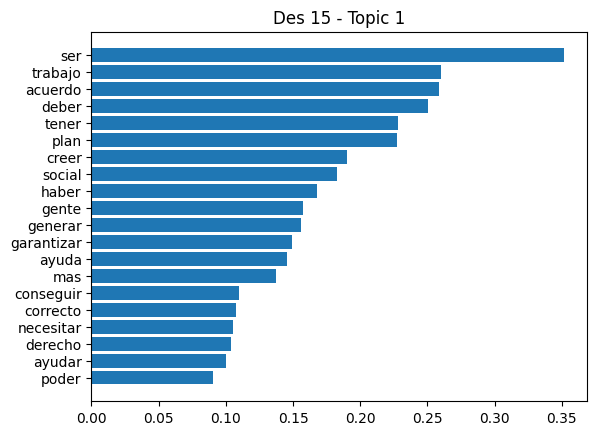

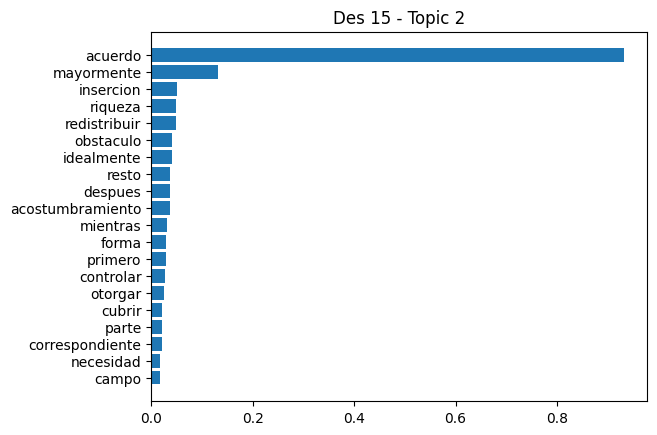

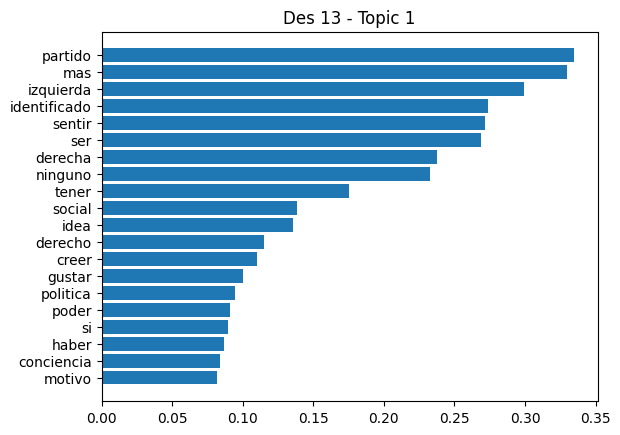

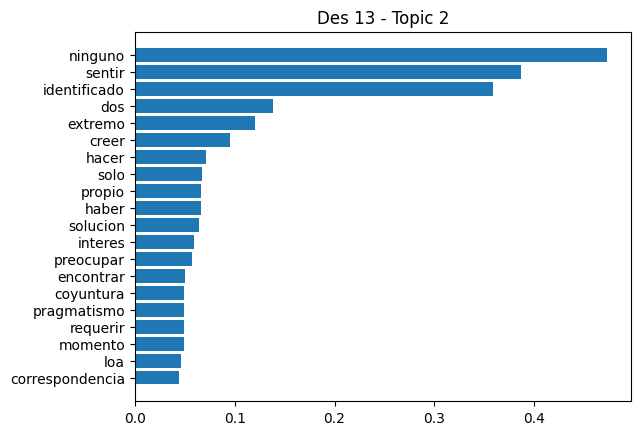

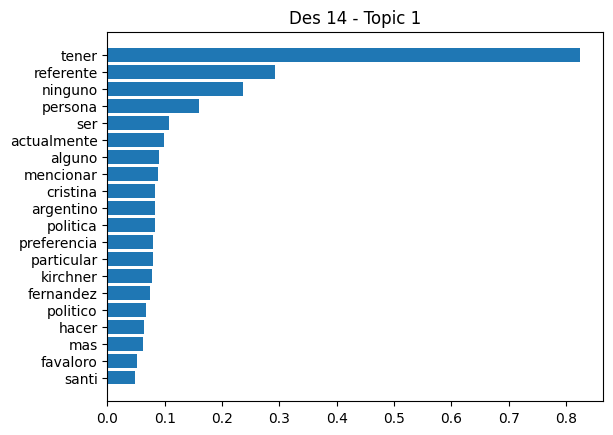

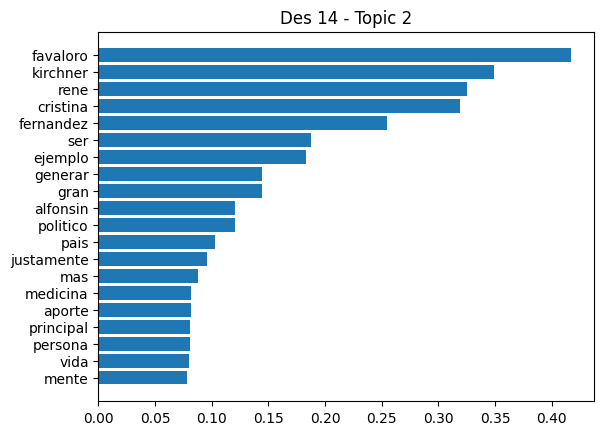

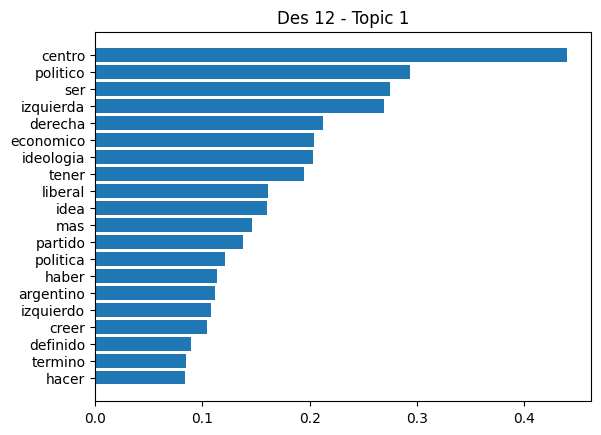

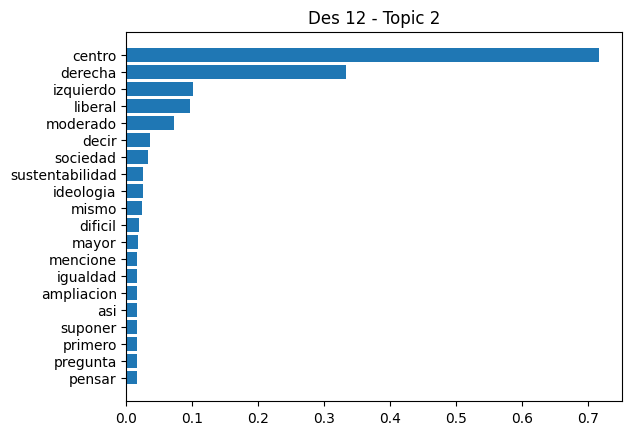

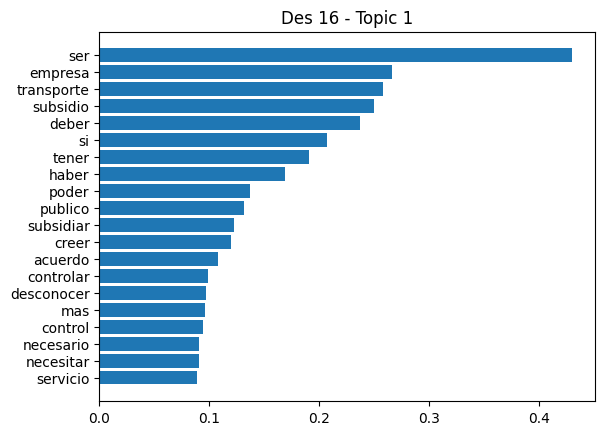

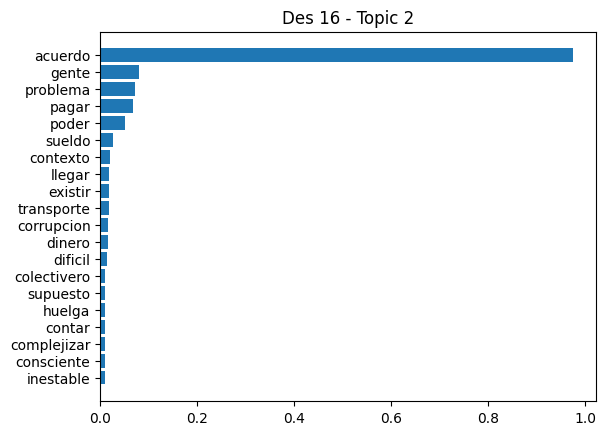

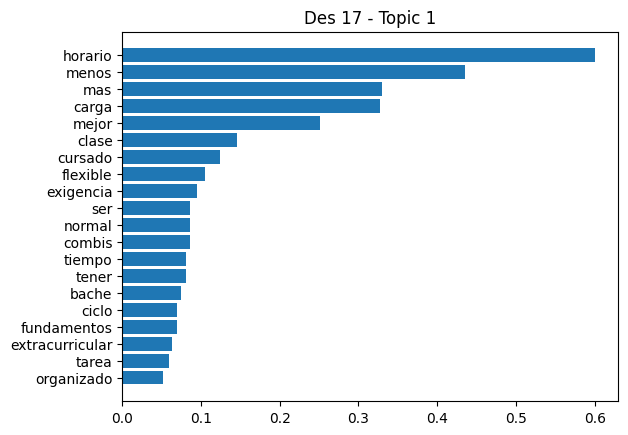

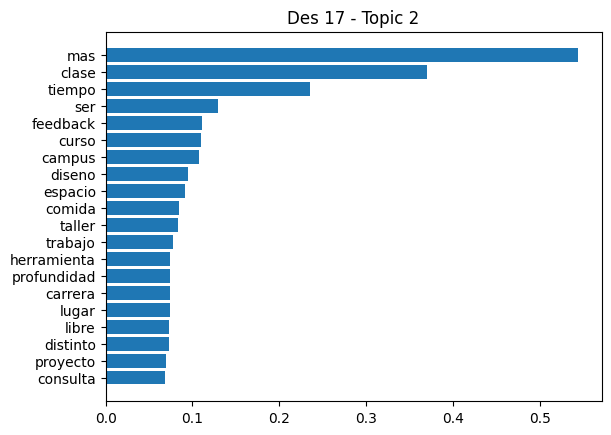

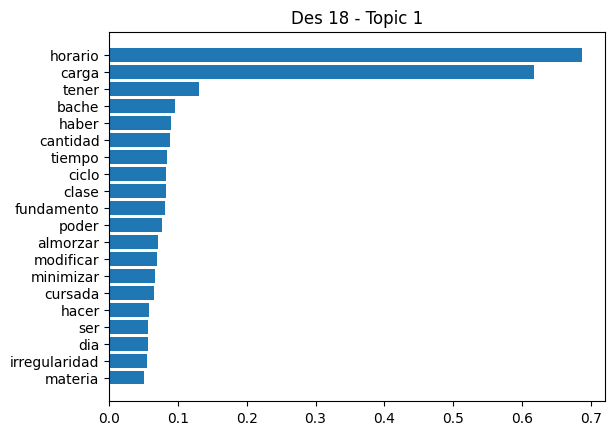

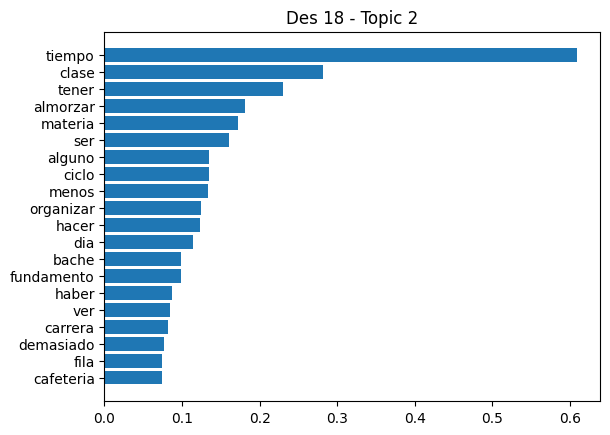

In [145]:
# Define data and model

n_components = 2 # nro de topicos a encontrar

for des, textos in df_desafio.items():
    
    documents = [' '.join(t) for t in textos]
    model = TruncatedSVD

    words, wheights = words_wheights(model, documents, n_components)


    for i in range(n_components):
        plot_word(words[i], wheights[i], plot_title = f'Des {des} - Topic {i+1}')

### Evaluacion

Recordemos que la cantidad de tópicos a encontrar es un hiperparametro. Para encontrar la cantidad óptima de tópicos, podemos realizar los siguientes pasos:

1. aumentar iterativamente la cantidad de tópicos a encontrar
2. evaluar la similitud coseno promedio entre todos los pares de tópicos (cuantos mas tópicos, menor sera la similitud promedio)
3. graficar la relacion entre cantidad de tópicos y similitud entre ellos
4. decidir el numero optimo de tópicos

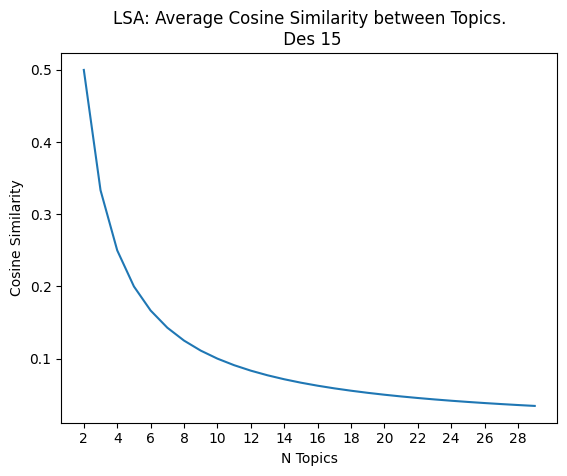

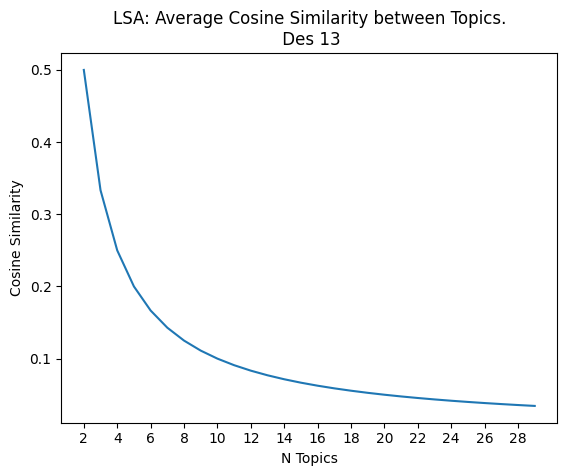

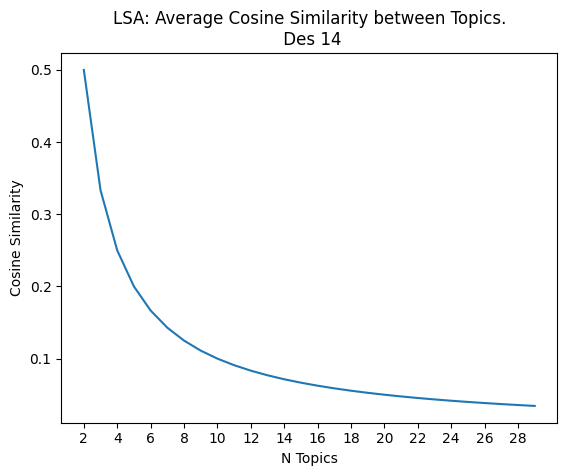

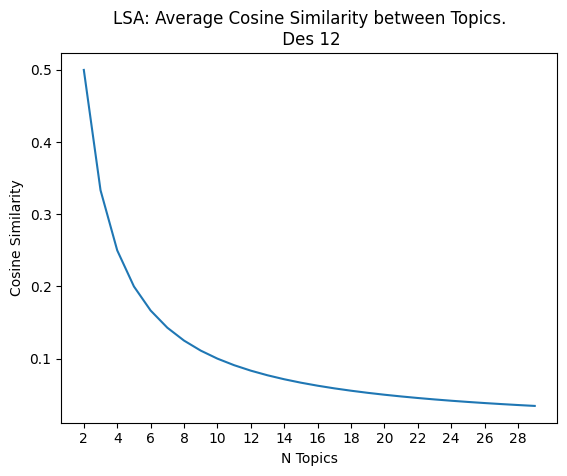

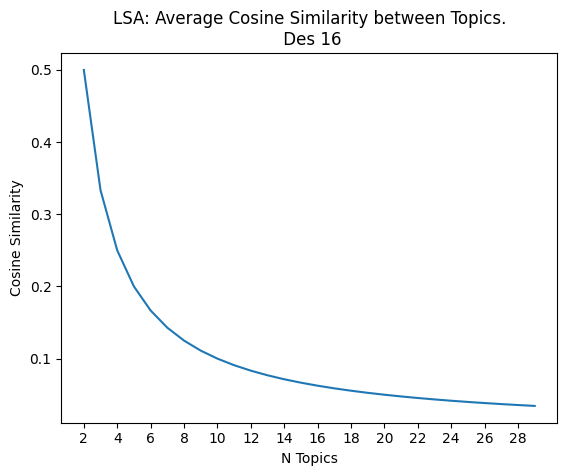

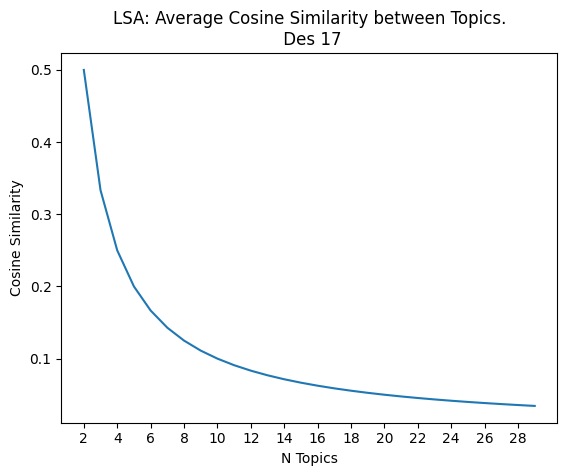

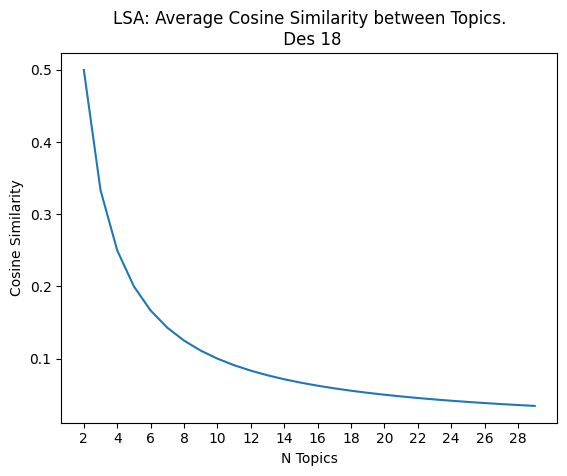

In [146]:
for des, textos in df_desafio.items():
    
    documents = [' '.join(t) for t in textos]
    
    n_topics = 30

    all_cs = []
    for i in range(2, n_topics):
        mean_cos_simil = evaluate_coherence(model, documents, n_topics = i)
        all_cs.append(mean_cos_simil)

    plt.plot(range(2, n_topics), all_cs)
    plt.title(f'LSA: Average Cosine Similarity between Topics.\n Des {des}')
    plt.xlabel('N Topics')
    plt.ylabel('Cosine Similarity')
    plt.xticks(range(2, n_topics, 2), range(2, n_topics, 2))
    plt.show()

Reducimos la dimensionalidad de los topicos en dos dimensiones y graficamos su distribucion

Every topic with its most relevant words.


Topic 0 = ser, trabajo, acuerdo

Topic 1 = acuerdo, mayormente, redistribuir

Topic 2 = garantizar, deber, creer

Topic 3 = correcto, gente, querer



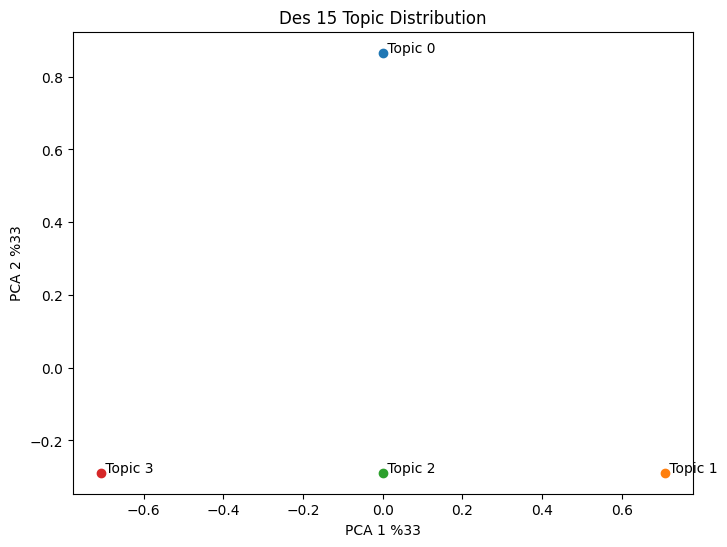

Every topic with its most relevant words.


Topic 0 = partido, mas, izquierda

Topic 1 = ninguno, sentir, identificado

Topic 2 = social, conciencia, tener

Topic 3 = ideologia, derecha, centro



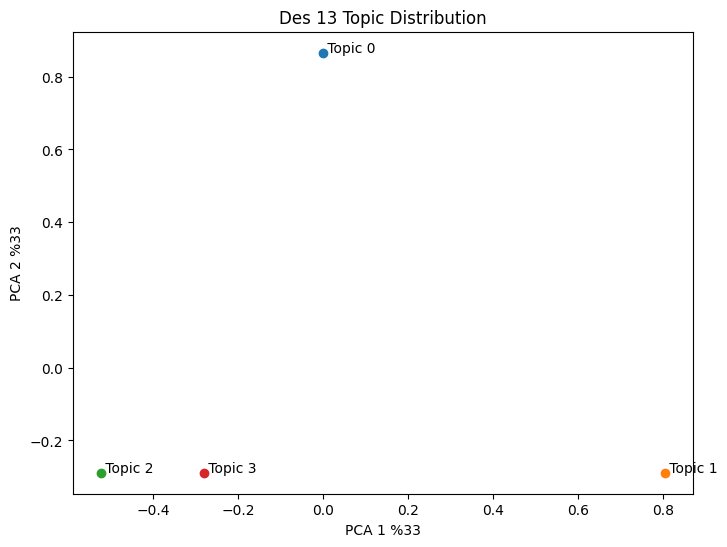

Every topic with its most relevant words.


Topic 0 = tener, referente, ninguno

Topic 1 = favaloro, kirchner, rene

Topic 2 = favaloro, rene, ejemplo

Topic 3 = ninguno, messi, actualmente



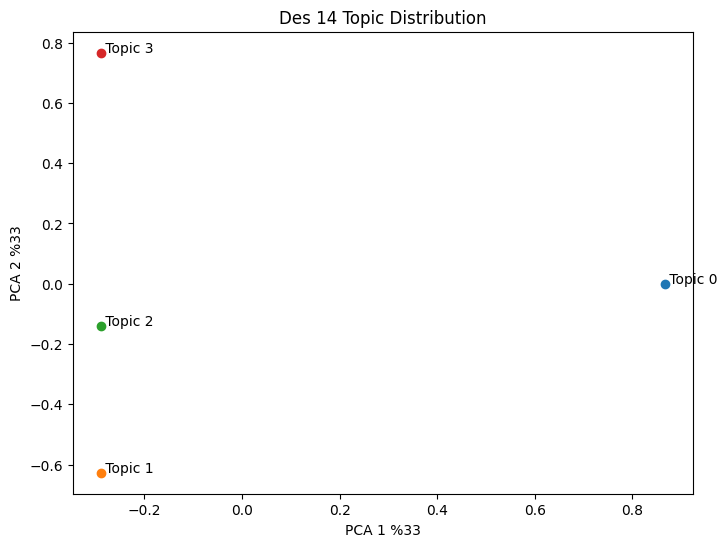

Every topic with its most relevant words.


Topic 0 = centro, politico, ser

Topic 1 = centro, derecha, liberal

Topic 2 = izquierda, estructuralista, latam

Topic 3 = peronista, hacer, pais



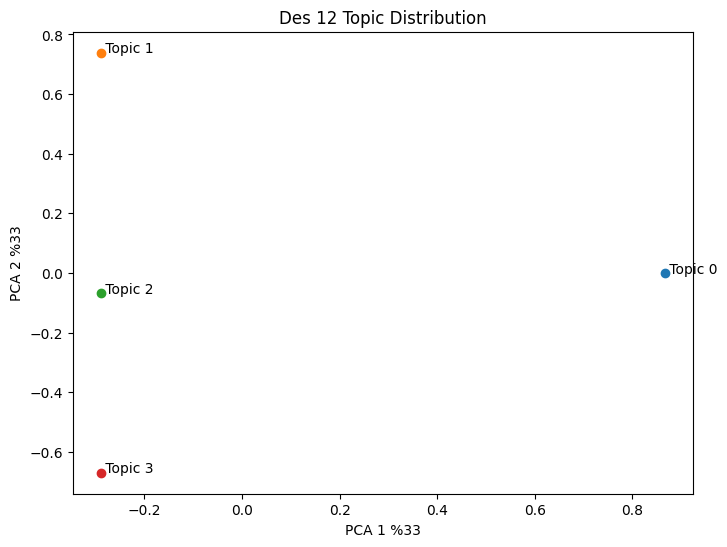

Every topic with its most relevant words.


Topic 0 = ser, empresa, transporte

Topic 1 = acuerdo, gente, problema

Topic 2 = responder, opinion, tema

Topic 3 = ser, subsidiar, bien



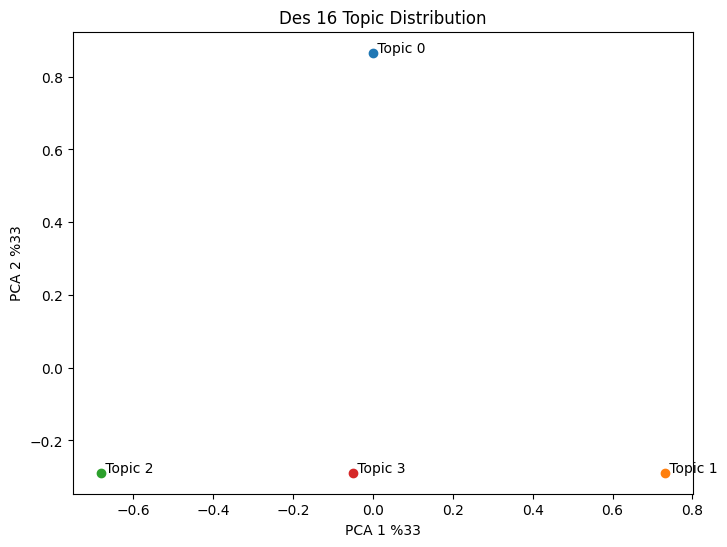

Every topic with its most relevant words.


Topic 0 = horario, menos, mas

Topic 1 = mas, clase, tiempo

Topic 2 = curso, diseno, extracurricular

Topic 3 = comida, kiosco, opcion



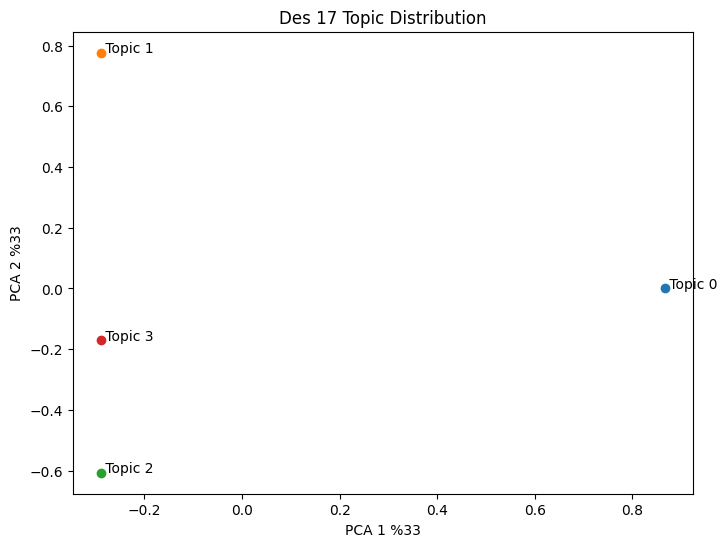

Every topic with its most relevant words.


Topic 0 = horario, carga, tener

Topic 1 = tiempo, clase, tener

Topic 2 = materia, fundamento, ciclo

Topic 3 = tiempo, ciclo, fundamento



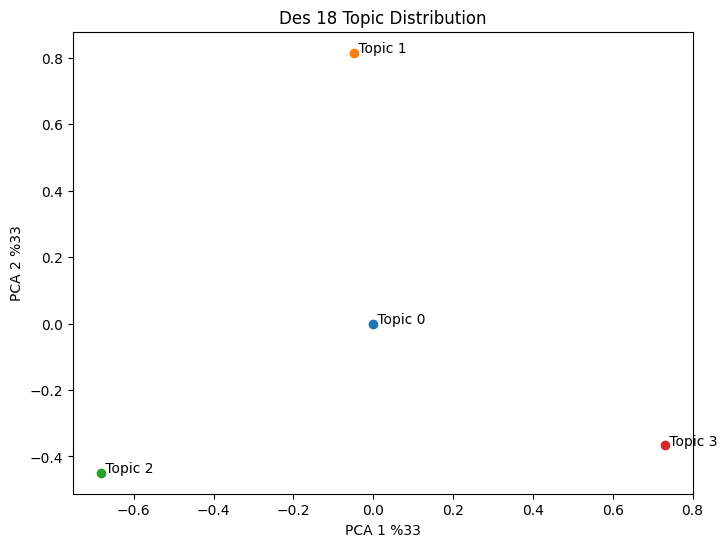

In [147]:
for des, textos in df_desafio.items():
    
    documents = [' '.join(t) for t in textos]
    
    num_top_words = 3

    visualize_topics(model, documents, num_top_words, n_components = 4, des=des) 

## 2. Latent Dirichlet  Allocation

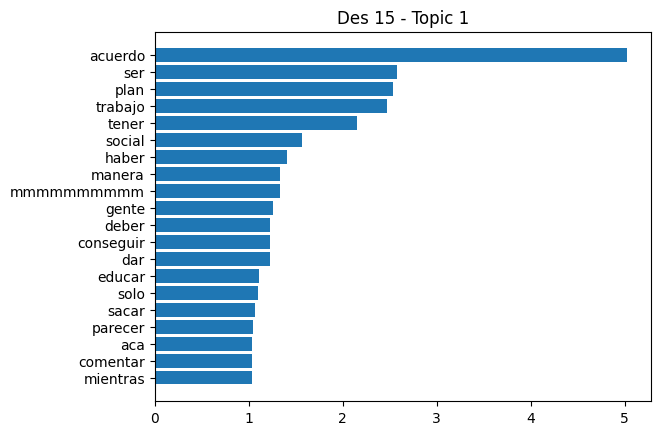

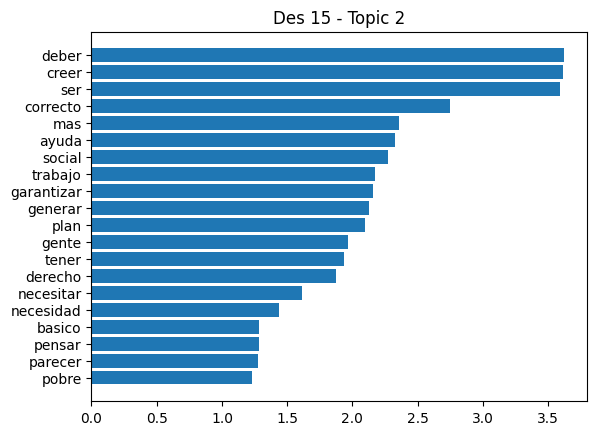

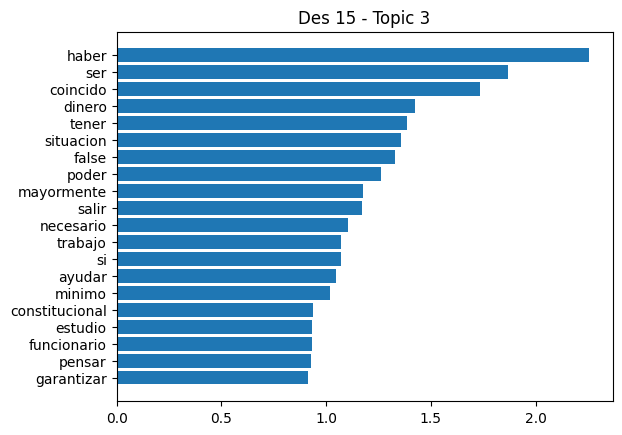

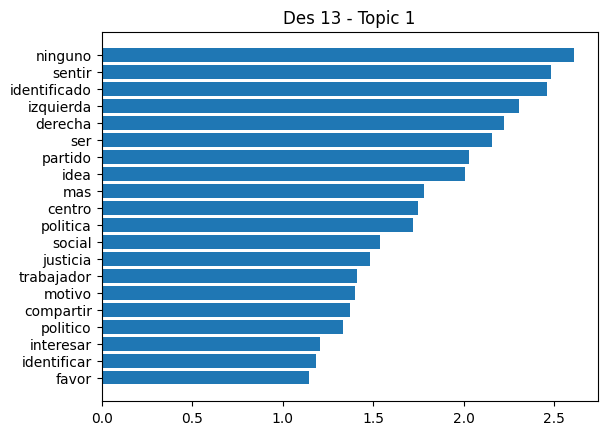

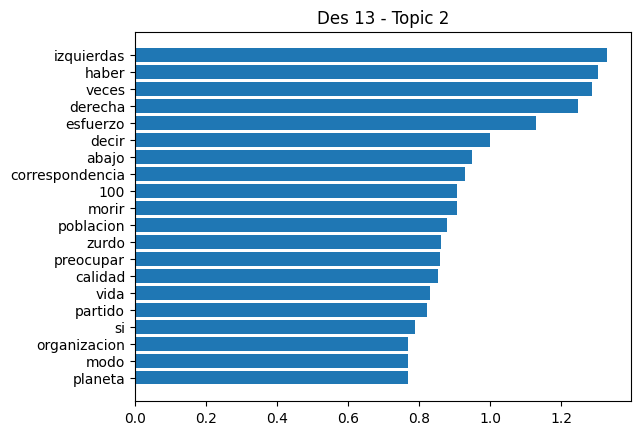

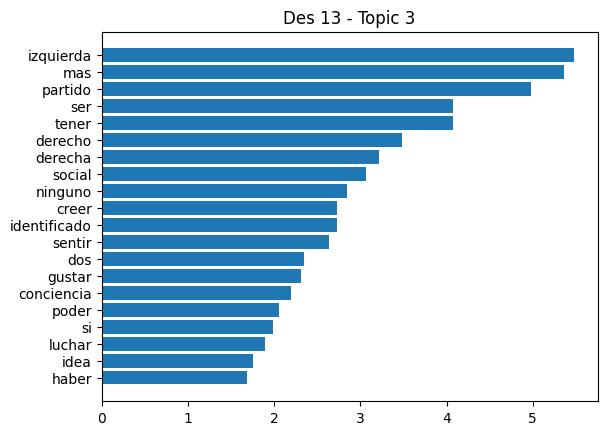

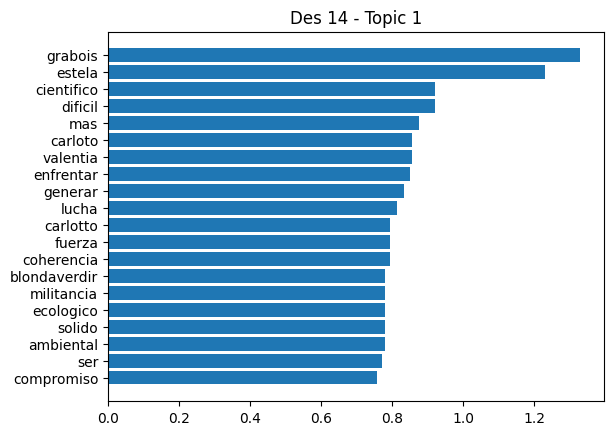

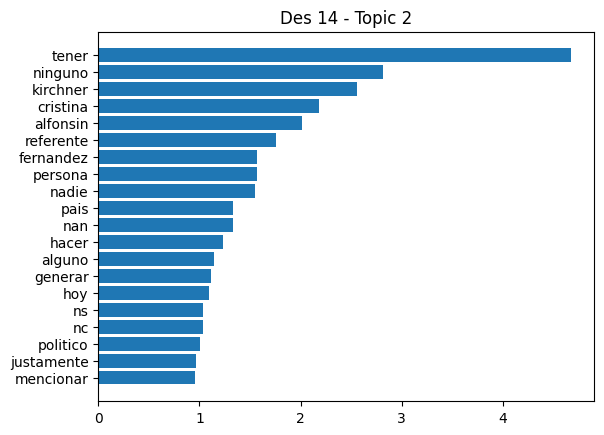

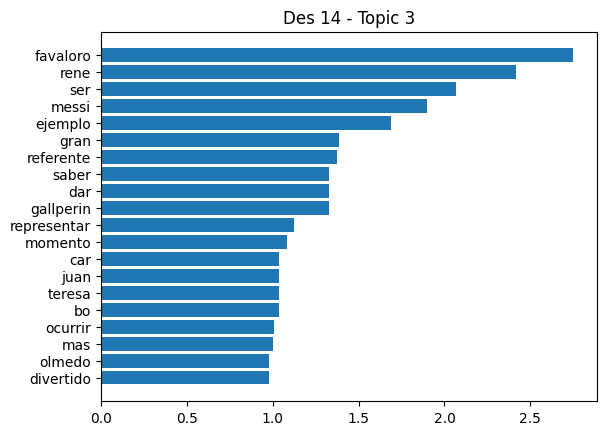

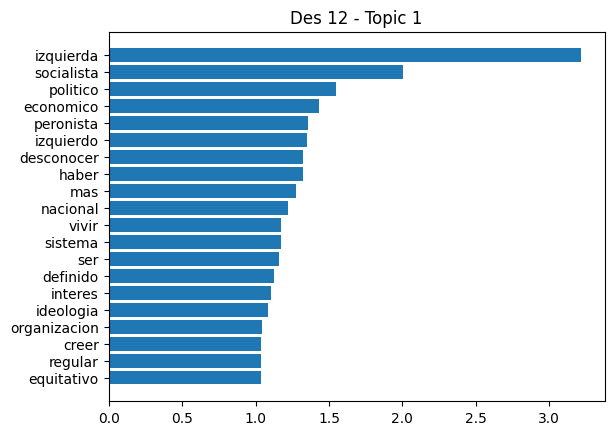

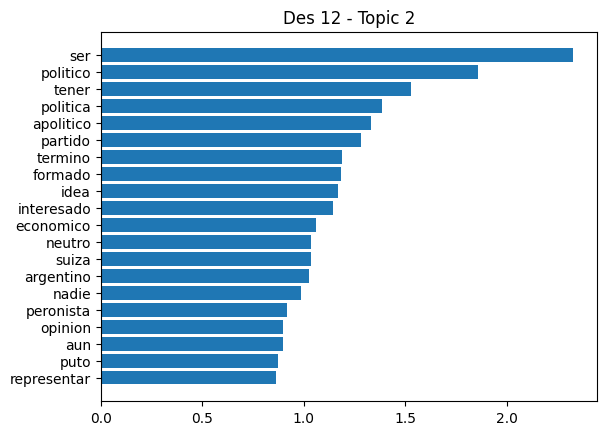

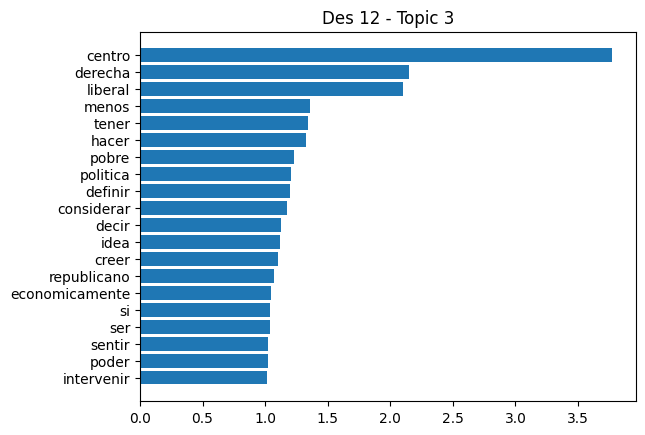

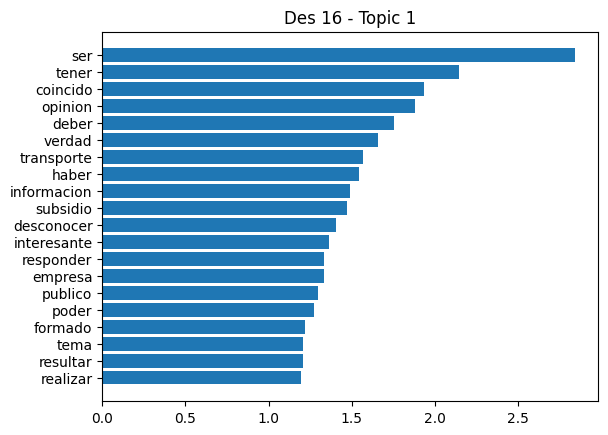

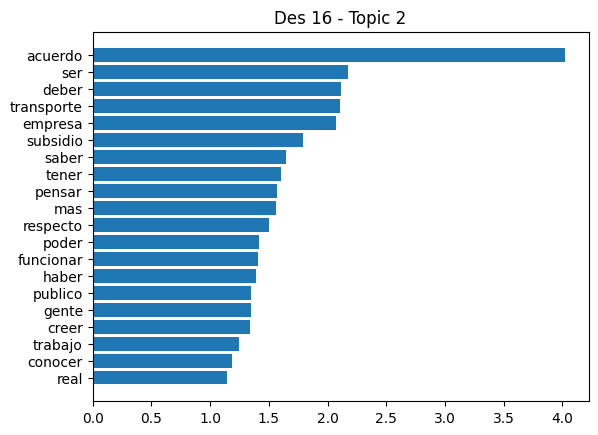

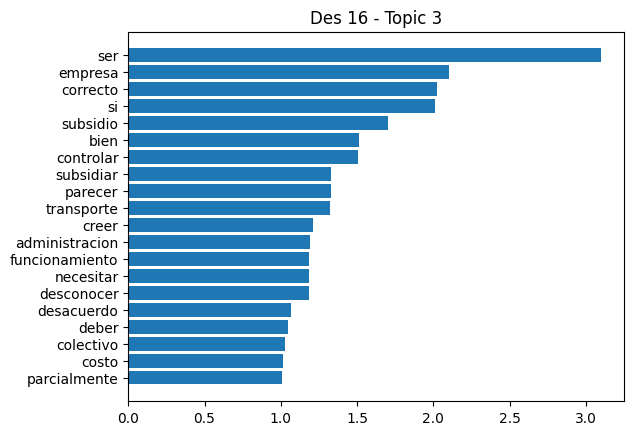

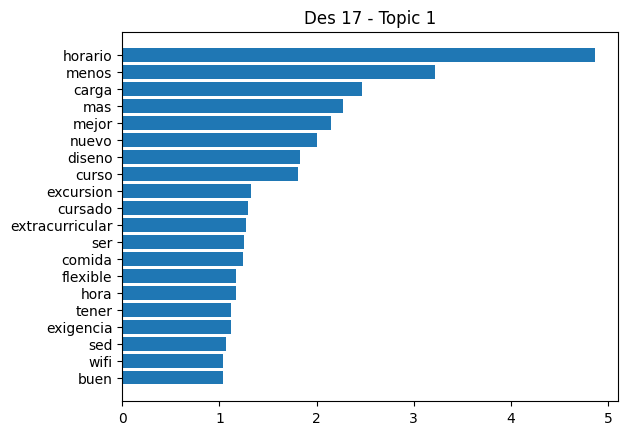

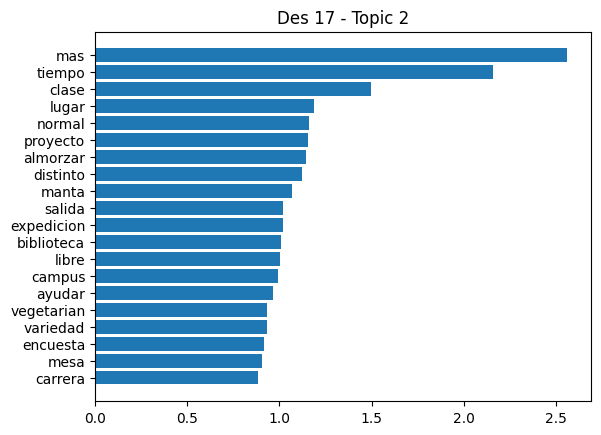

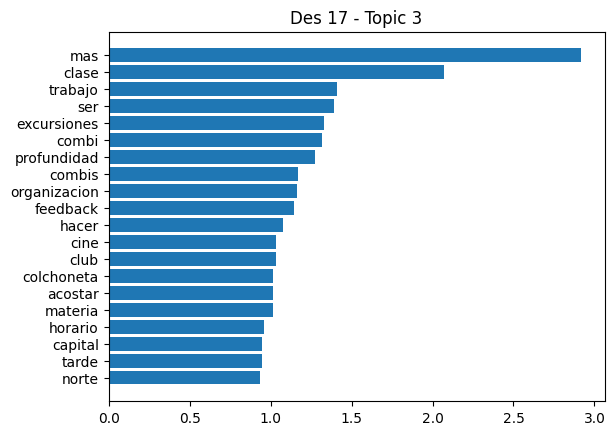

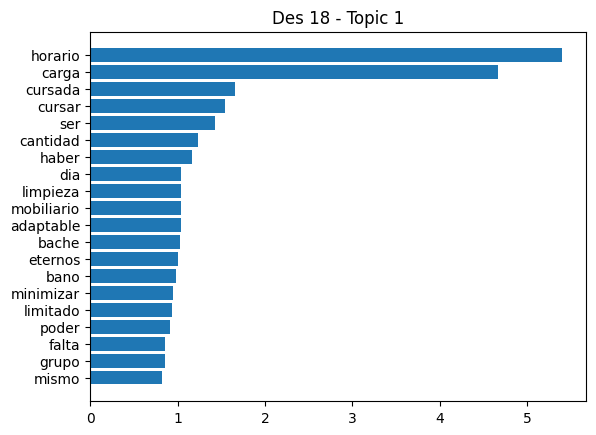

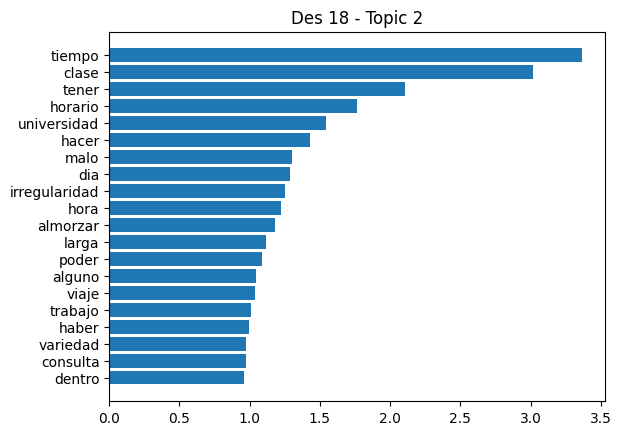

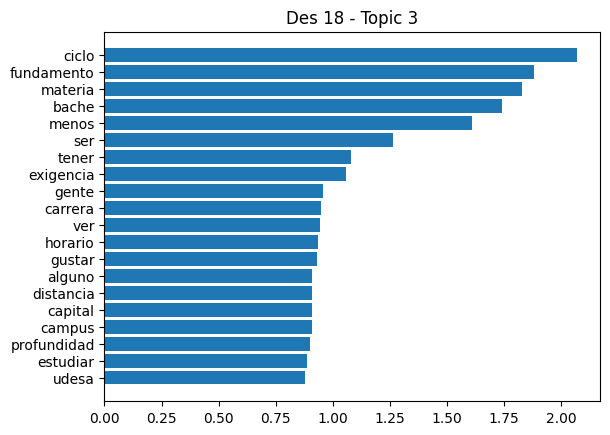

In [148]:
# Define data and model

n_components = 3

for des, textos in df_desafio.items():
    
    documents = [' '.join(t) for t in textos]
    model = LatentDirichletAllocation
    

    words, wheights = words_wheights(model, documents, n_components)
    
    for i in range(n_components):
        plot_word(words[i], wheights[i], plot_title = f'Des {des} - Topic {i+1}')

### Evaluacion

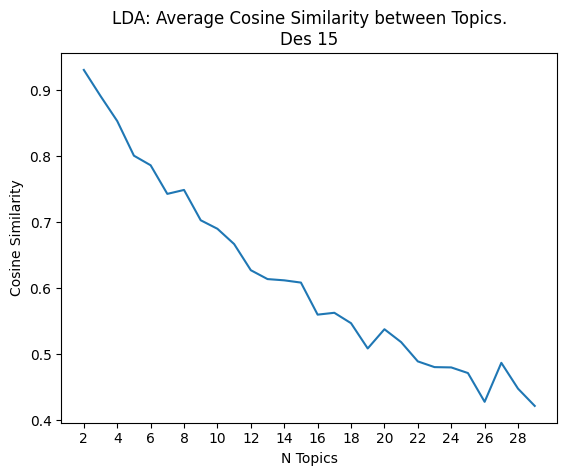

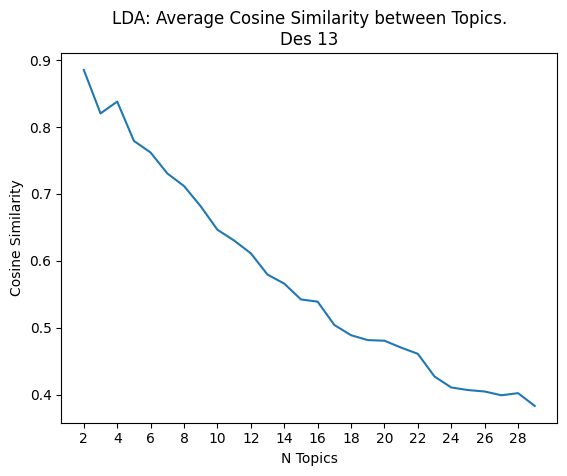

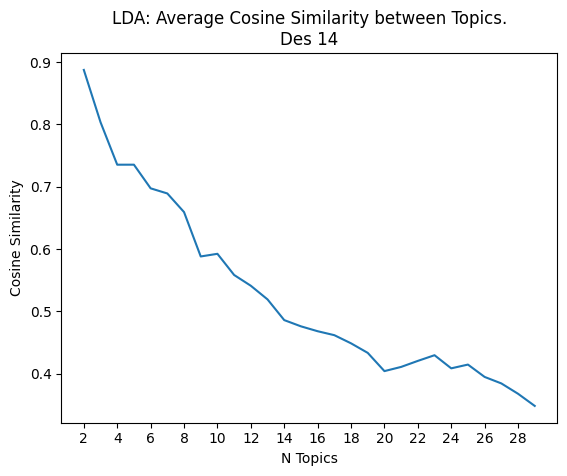

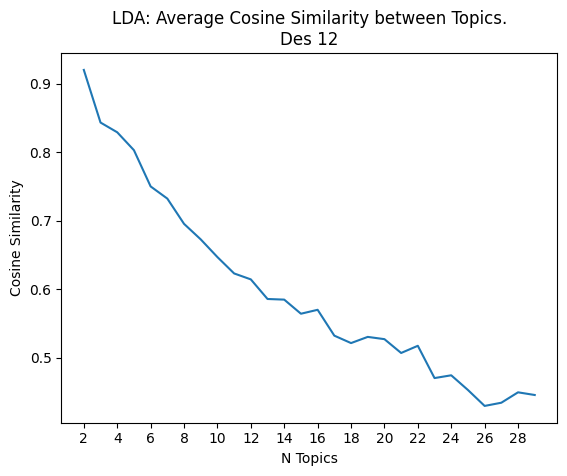

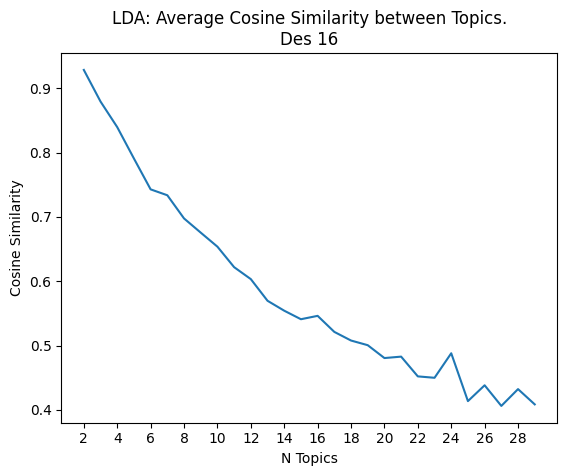

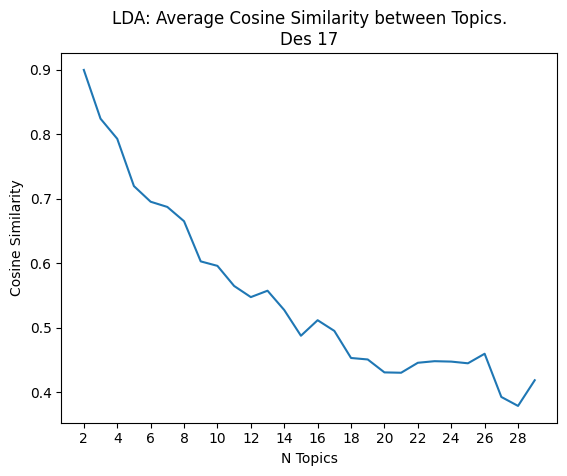

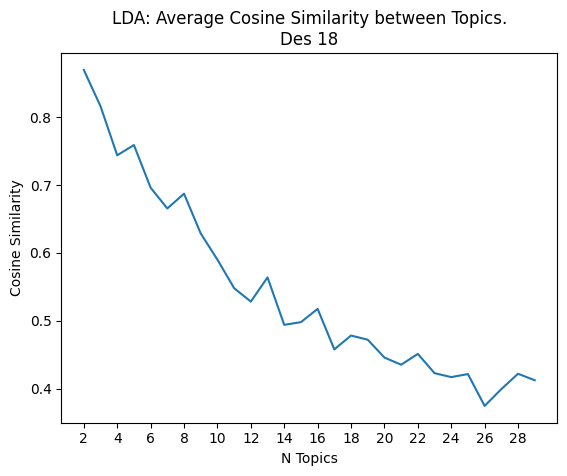

In [149]:
for des, textos in df_desafio.items():
    
    # Define data
    documents = [' '.join(t) for t in textos]

    n_topics = 30

    all_cs = []
    for i in range(2, n_topics):
        mean_cos_simil = evaluate_coherence(model, documents, n_topics = i)
        all_cs.append(mean_cos_simil)

    plt.plot(range(2, n_topics), all_cs)
    plt.title(f'LDA: Average Cosine Similarity between Topics.\nDes {des}')
    plt.xlabel('N Topics')
    plt.ylabel('Cosine Similarity')
    plt.xticks(range(2, n_topics, 2), range(2, n_topics, 2))
    plt.show()

Every topic with its most relevant words.


Topic 0 = situacion, ser, salir, poblacion

Topic 1 = ser, correcto, trabajo, social

Topic 2 = ser, haber, tener, deber

Topic 3 = acuerdo, ser, deber, garantizar



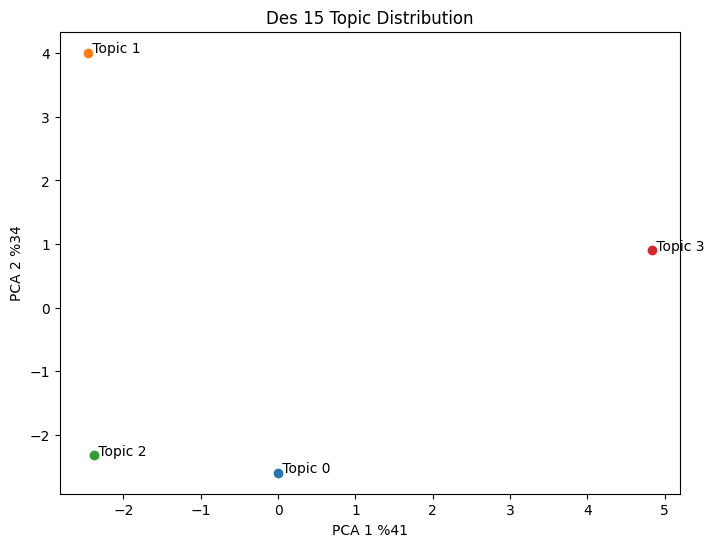

Every topic with its most relevant words.


Topic 0 = izquierda, derecha, partido, social

Topic 1 = identificado, sentir, partido, ninguno

Topic 2 = mas, conciencia, tener, izquierda

Topic 3 = izquierda, partido, ser, derecha



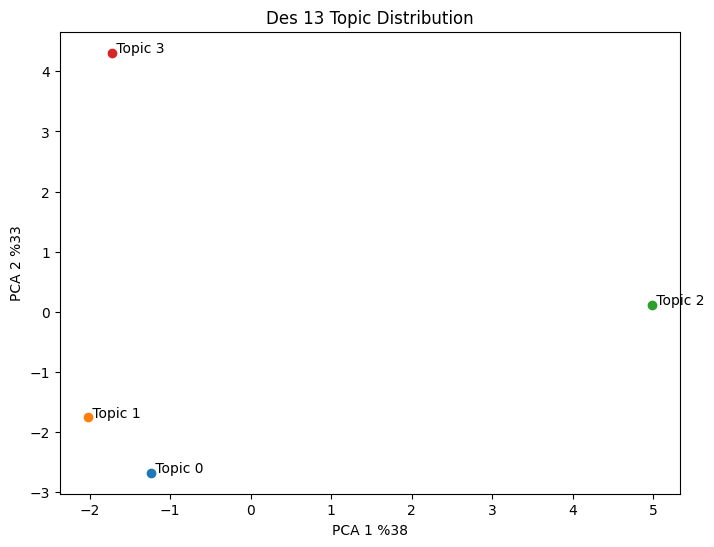

Every topic with its most relevant words.


Topic 0 = generar, gran, martin, bo

Topic 1 = tener, favaloro, rene, ser

Topic 2 = ninguno, tener, referente, alfonsin

Topic 3 = fernandez, cristina, ocurrir, olmedo



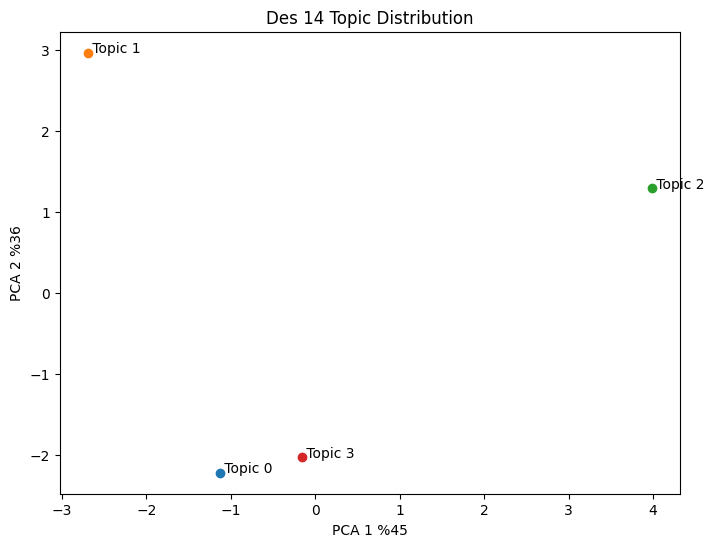

Every topic with its most relevant words.


Topic 0 = derecha, centro, peronista, derecho

Topic 1 = politico, ser, tener, izquierda

Topic 2 = liberal, desconocer, izquierda, centro

Topic 3 = centro, argentino, ser, politico



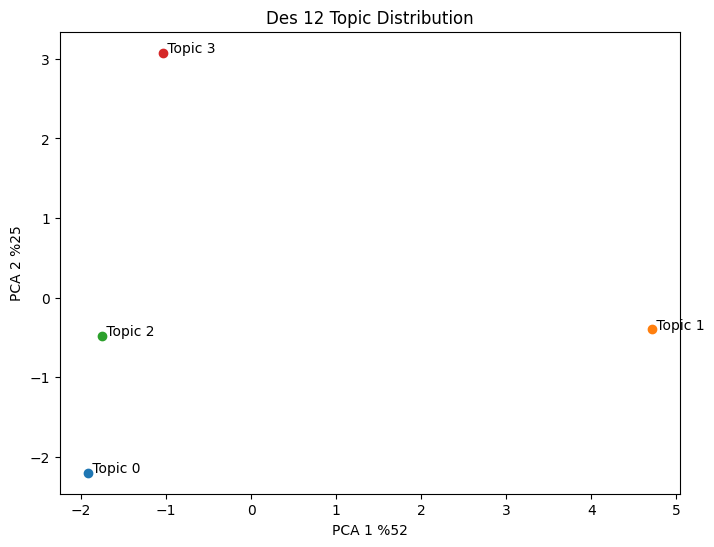

Every topic with its most relevant words.


Topic 0 = responder, ser, poder, tener

Topic 1 = deber, coincido, ser, empresa

Topic 2 = acuerdo, ser, desconocer, si

Topic 3 = ser, controlar, empresa, verdad



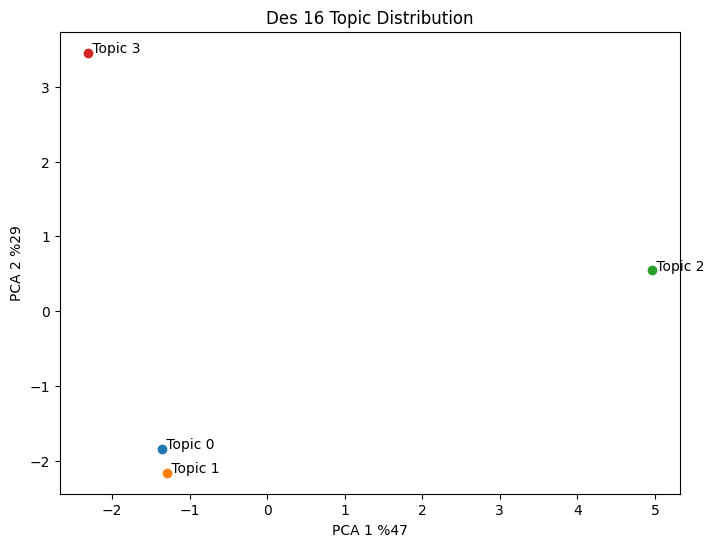

Every topic with its most relevant words.


Topic 0 = mas, diseno, curso, organizacion

Topic 1 = excursiones, mas, flexible, tiempo

Topic 2 = nuevo, mas, kiosco, profundidad

Topic 3 = horario, mas, menos, carga



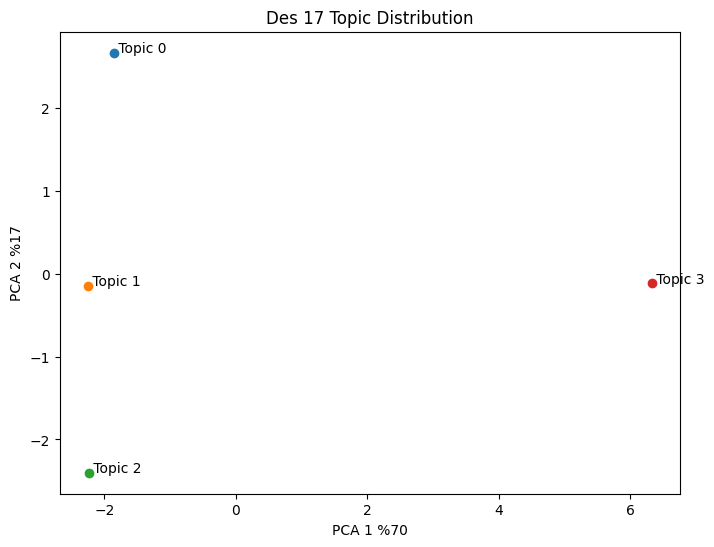

Every topic with its most relevant words.


Topic 0 = tiempo, materia, bache, clase

Topic 1 = horario, carga, tener, tiempo

Topic 2 = falta, irregularidad, ser, limitado

Topic 3 = cursar, universidad, horario, dia



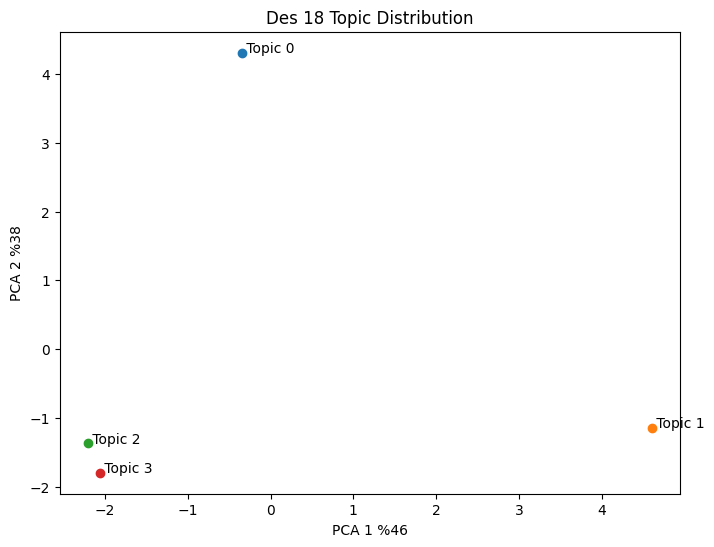

In [150]:
for des, textos in df_desafio.items():
    
    # Define data
    documents = [' '.join(t) for t in textos]

    num_top_words = 4

    visualize_topics(model, documents, num_top_words, n_components=4, des=des)

## 3. BERTopic 

- [Documentation](https://maartengr.github.io/BERTopic/api/bertopic.html)
- [Friendly Documentation](https://maartengr.github.io/BERTopic/index.html)
- [Use Case Example](https://www.pinecone.io/learn/bertopic/)

In [151]:
# dict with desafio and its preprocesed texts
df_desafio = {}
for des in df.desafio.unique():
    value = df[df['desafio']==des].texto.tolist()
    value = preprocess(value, lemma=False)
    value = [' '.join(d) for d in value]
    df_desafio[des] = value

In [175]:
from IPython.display import display, Markdown

def bertopic_plots(model, documents, des):
    
    """
    This function plots every relevant BERTopic plot. 
    
    Input:
    a. model: BERTopic
    b. documents: preprocessed
    c. des: name of desafio
    
    Output: none
    
    """
    
    
    topics, probs = model.fit_transform(documents)
    
    
    
    # Define the text to display
    text = f'<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío {des}</span></div>'

    # Get the unique Topics and their frequencies
    unique_elements, counts = np.unique(topics, return_counts=True)
    
    plt.bar(unique_elements, counts)
    
    # Add axis labels and a title
    plt.xlabel('Topic')
    plt.ylabel('Frequency (N of documents)')
    plt.xticks(unique_elements)
    plt.title(f'Frequency of each Topic\nDes {des}')

    # Visualize topics
    fig_vt = model.visualize_topics()

    # Importance of each word
    fig_w = model.visualize_barchart(top_n_topics=len(model.get_topics()))
    
    # Vistualize documents
    fig_vd = model.visualize_documents(documents, hide_annotations=True)
    
    # Heatmap topics
    fig_hm = model.visualize_heatmap()

    #Show images
    print('\n\n')
    display(Markdown(text))
    
    plt.show()
    fig_vt.show()
    fig_w.show()
    fig_vd.show()
    fig_hm.show()
    
    try:
        # Most representative documents
        original_texts = df['texto'].values.tolist()
        prepro_texts = preprocess(df['texto'], lemma=False)
        prepro_texts = [' '.join(d) for d in prepro_texts]

        for key, value in model.get_representative_docs().items():
            print('\n'*4),print(f'TOPIC {key} most representative documents:\n')
            for i, doc in enumerate(value):
                indice = prepro_texts.index(doc)
                print(f'{i+1}.\n {original_texts[indice]}\n\n')
    except:
        pass

In [174]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import MiniBatchKMeans

cluster_model = MiniBatchKMeans(n_clusters=4) # KNN como alternativa a HDBSCAN

def bert_model_create(cluster_model = None):
    embedding_model = SentenceTransformer('bert-base-nli-mean-tokens') # embedings pre entrenado en español
    umap_model = UMAP(n_neighbors=3)
    
    # Kmeans works better for small desafio, HDBSCAN for big ones
    if not cluster_model:
        cluster_model = HDBSCAN(gen_min_span_tree=True, prediction_data=True)

    # Bag of words
    vectorizer_model = CountVectorizer(ngram_range=(1, 3))
    
    model = BERTopic(
        vectorizer_model = vectorizer_model,
        umap_model = umap_model,
        hdbscan_model = cluster_model,
        embedding_model = embedding_model,
        language='spanish',
        calculate_probabilities=True,
        verbose=True,
        min_topic_size = 3,            # most important hyperparameter for small dataset (lower it)
        nr_topics="auto"
    )
    
    return model

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-20 13:15:58,671 - BERTopic - Transformed documents to Embeddings
2022-12-20 13:15:59,968 - BERTopic - Reduced dimensionality
2022-12-20 13:15:59,976 - BERTopic - Clustered reduced embeddings
2022-12-20 13:16:01,546 - BERTopic - Reduced number of topics from 5 to 5


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 12</span></div>

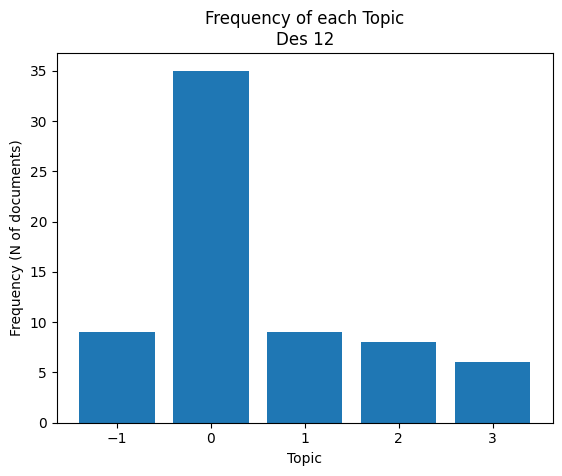






TOPIC 3 most representative documents:

1.
 Me definiría como liberal. El estado no tiene por que intervenir en el mercado, por lo que hemos vivido hasta ahora en este país, queda demostrado.


2.
 No tengo una posición muy formada, pero me identifico con el liberalismo. Completamente liberal en lo social, y relativamente en lo económico. 


3.
 Centro - liberal







TOPIC 2 most representative documents:

1.
 Me defino como kirchnerista. Soberania política, independencia económica y justocia social.


2.
 No tengo ni puta idea que es un termino politico economico


3.
 No tengo una ideología política económica definida







TOPIC 0 most representative documents:

1.
 Clase media, trabajador. Porque vivo trabajando para mantenerme a mi y a mi familia.


2.
 Desconozco


3.
 Estructuralista LATAM. Izquierda







TOPIC 1 most representative documents:

1.
 Pragmático: equilibrar el déficit fiscal, fomentar el trabajo y la mentalidad emprendedora, facilitar crédito y exención i

In [154]:
key = '12'

documents = df_desafio[key]

model = bert_model_create()
bertopic_plots(model, documents, key)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-20 13:16:54,366 - BERTopic - Transformed documents to Embeddings
2022-12-20 13:16:55,676 - BERTopic - Reduced dimensionality
2022-12-20 13:16:55,686 - BERTopic - Clustered reduced embeddings
2022-12-20 13:16:57,365 - BERTopic - Reduced number of topics from 6 to 6


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 13</span></div>

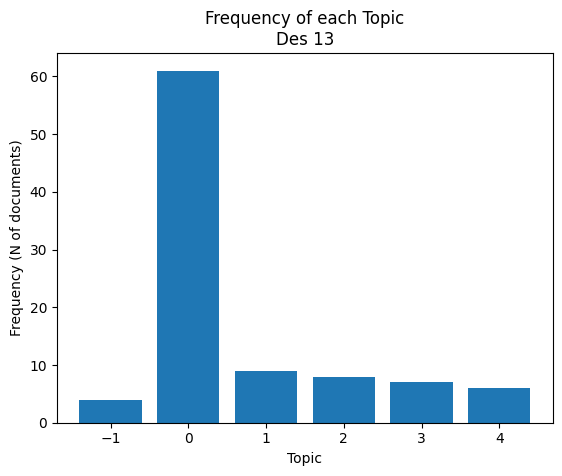






TOPIC 2 most representative documents:

1.
 Más de izquierda, por sus ideas y propuestas y conceptos en relación a la situación económica y social. 


2.
 Me siento identificada socialmente con partidos de izquierda pero económicamente con partidos de centro. Nada de derecha. Pienso que tenemos que abogar por las libertades sociales pero a la vez económicamente no se puede librar todo a la suerte del mercado, así que creo que se necesita algún control


3.
 Con el centro. Tiene que existir un equilibrio entre conciencia social y economía.







TOPIC 4 most representative documents:

1.
 Ni con unos ni con otros, porque no han servido ni sirven las ultranzas para resolver los problemas de la gente, al menos en Argentina. Yo creo en gobiernos pragmáticos al servicio de toda la población (TODA), y si alguna vez apareciera en nuestro contexto esa posibilidad debería adoptar las mejores políticas y prácticas de gestión, integrando ideas de derecha, izquierda y centro.Creo además que 

In [155]:
key = '13'

documents = df_desafio[key]

model = bert_model_create()
bertopic_plots(model, documents, key)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-20 13:20:50,459 - BERTopic - Transformed documents to Embeddings
2022-12-20 13:20:51,760 - BERTopic - Reduced dimensionality
2022-12-20 13:20:51,846 - BERTopic - Clustered reduced embeddings
2022-12-20 13:20:52,781 - BERTopic - Reduced number of topics from 4 to 4


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 14</span></div>

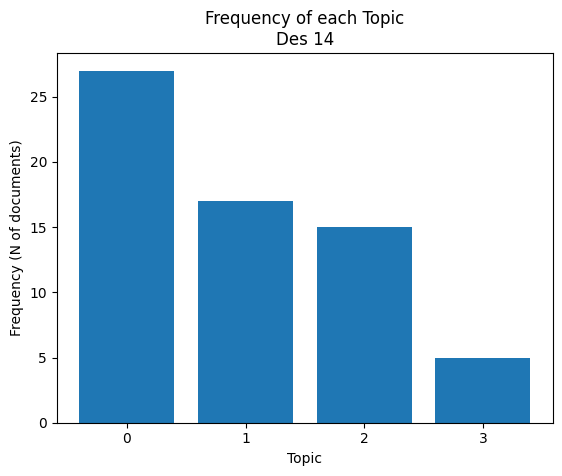

AttributeError: 'NoneType' object has no attribute 'items'

In [159]:
key = '14'

documents = df_desafio[key]


cluster_model = MiniBatchKMeans(n_clusters=4) # Probamos con KNN


model = bert_model_create(cluster_model)
bertopic_plots(model, documents, key)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-20 13:27:21,458 - BERTopic - Transformed documents to Embeddings
2022-12-20 13:27:22,763 - BERTopic - Reduced dimensionality
2022-12-20 13:27:22,772 - BERTopic - Clustered reduced embeddings
2022-12-20 13:27:23,797 - BERTopic - Reduced number of topics from 5 to 5


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 15</span></div>

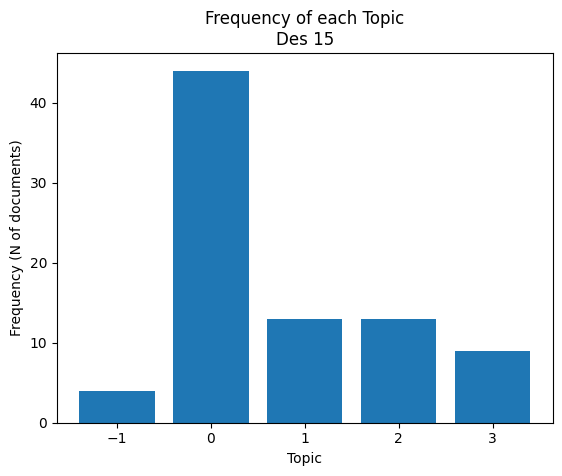






TOPIC 0 most representative documents:

1.
 Creo que la asistencia social debe existir pero debe estar mas regulada y auditada. Tambien sería bueno que ademas fomente la reinserción laboral a travez capacitaciones y de periodos limitados del goce de los mismos .


2.
 Mayormente de acuerdo


3.
 Me parece una afirmación muy acertada







TOPIC 2 most representative documents:

1.
 Creo que tiene coherencia porque el ingreso ciudadano equilibra los desvíos que genera las economías de acumulación


2.
 Creo que la ayuda a los pobres de manera directa es una decisión táctica  pero terminó convirtiéndose en estratégica . Creo en un Estado que controle la economía pero también que genere propuestas de desarrollo para que haya trabajo que es el verdadero ordenador social.


3.
 Desde hace muchos años los planes sociales vienen siendo la herramienta que no solo da una ayuda económica a los beneficiarios, sino que se utilizan para realizar mejoras en los barrios populares (huertas, limp

In [173]:
key = '15'

documents = df_desafio[key]

model = bert_model_create()
bertopic_plots(model, documents, key)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2022-12-20 13:29:39,575 - BERTopic - Transformed documents to Embeddings
2022-12-20 13:29:41,565 - BERTopic - Reduced dimensionality
2022-12-20 13:29:41,622 - BERTopic - Clustered reduced embeddings
2022-12-20 13:29:42,827 - BERTopic - Reduced number of topics from 4 to 4


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 16</span></div>

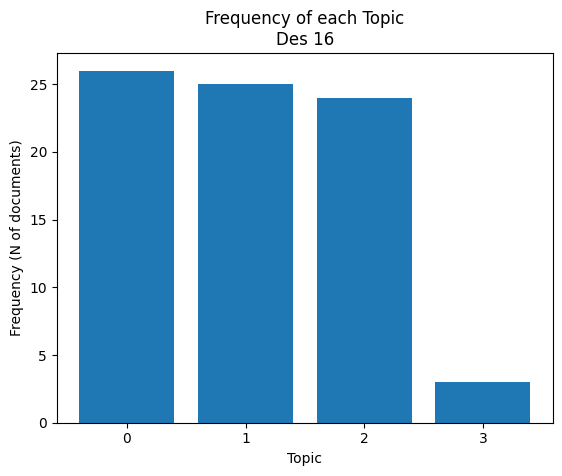

AttributeError: 'NoneType' object has no attribute 'items'

In [178]:
key = '16'

documents = df_desafio[key]

cluster_model = MiniBatchKMeans(n_clusters=4) # Probamos con KNN

model = bert_model_create(cluster_model)
bertopic_plots(model, documents, key)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-20 13:32:31,099 - BERTopic - Transformed documents to Embeddings
2022-12-20 13:32:32,403 - BERTopic - Reduced dimensionality
2022-12-20 13:32:32,459 - BERTopic - Clustered reduced embeddings
2022-12-20 13:32:33,453 - BERTopic - Reduced number of topics from 4 to 4


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 17</span></div>

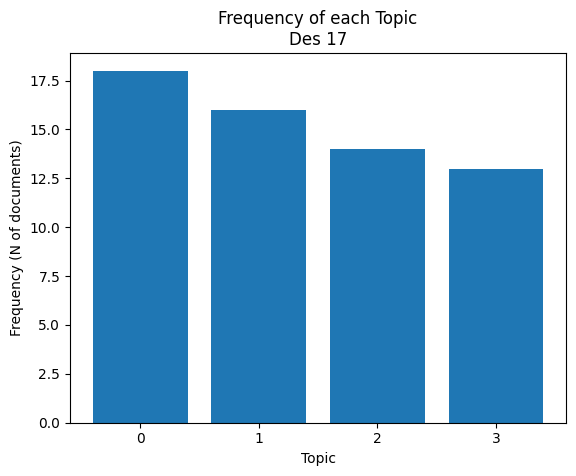

AttributeError: 'NoneType' object has no attribute 'items'

In [183]:
key = '17'

documents = df_desafio[key]

cluster_model = MiniBatchKMeans(n_clusters=4) # Probamos con KNN

model = bert_model_create(cluster_model)
bertopic_plots(model, documents, key)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2022-12-20 13:33:30,259 - BERTopic - Transformed documents to Embeddings
2022-12-20 13:33:31,558 - BERTopic - Reduced dimensionality
2022-12-20 13:33:31,741 - BERTopic - Clustered reduced embeddings
2022-12-20 13:33:32,846 - BERTopic - Reduced number of topics from 4 to 4


<div style="text-align:center;"><span style="font-size:48px;color:blue;">Desafío 18</span></div>

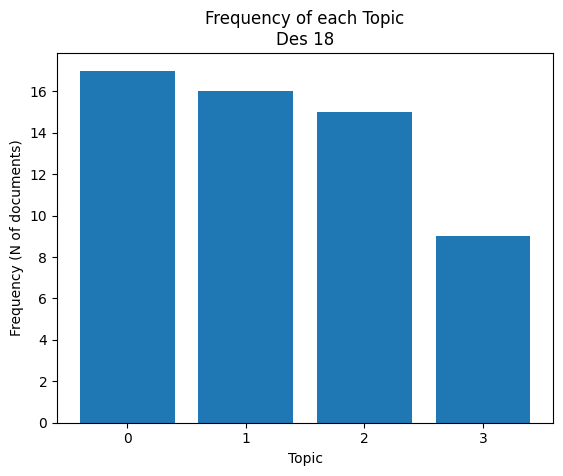

AttributeError: 'NoneType' object has no attribute 'items'

In [184]:
key = '18'

documents = df_desafio[key]

cluster_model = MiniBatchKMeans(n_clusters=4) # Probamos con KNN

model = bert_model_create(cluster_model)
bertopic_plots(model, documents, key)